# <center>Part I. Facial Recognition</center>

# <center>Two-Stage Facial Recognition and Classification Model Using Multi-Task Cascaded Convolutional Neural Networks and Inception-ResNet v1</center>

In [16]:
# General Imports
import numpy as np
import pandas as pd
import os, shutil

# For Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

# For Face Detector
import torch
from facenet_pytorch import MTCNN

# Executive Summary

This technical report outlines the creation of a two-stage model for:
1. Face Detection (Notebook 1)
2. Face Classification (Notebook 2)

The two-stage model utilized state-of-the-art deep learning and tools for both face detection and face classification tasks. For face detection, I used the `MTCNN` (Multi-Task Cascaded Convolutional Neural Networks), which is a deep learning algorithm built into the `facenet_pytorch`, an open-source facial recognition toolkit. For face classification, on the other hand, I used the `InceptionResNetV1` architecture, which was pre-trained on the `vggface2` dataset, a large-scale face recognition dataset. The two-stage model is capable of accurately extracting, cropping, and classifying each Capstone Team Member's face.

Getting to the results, the `face detector` was able to accurately detect faces with impressive prediction scores above **99%** especially for the Capstone Team Member's Faces.

Furthermore, the face classifier was trained for **50 epochs** and achieved an impressive test accuracy of **0.9643**. 

The model's success can be attributed to its use of powerful neural network architectures pre-trained on large datasets. 

This is part 1 of a 2-part Notebook entitled *Two-Stage Facial Recognition and Classification Model Using Multi-Task Cascaded Convolutional Neural Networks and Inception-ResNet v1*.

# Loading the Dataset

We begin by loading and storing the file names of the image data from the `data\\images` directory into a list called `image_data`. The image data comprises both group and solo photos of each Capstone Team member from CPT1. In total, the raw data comprises 116 pictures.

In [3]:
# Specify file path
file_folder = 'data\\images'

# Store image file names in list
image_data = ([image_path for image_path in os.listdir(file_folder)])

# take the total number of images
total_images = len(image_data)

# Loading the Pretrained Face Detector Model

Next, we set the device variable to the available GPU device `cuda:0` if one is available or to `CPU` if a GPU is not available. Using a GPU will significantly speed up the training process.

We then load the face detector model. The face detector model utilized is `MTCNN` (Multi-Task Cascaded Convolutional Neural Networks) from the `facenet_pytorch` toolkit.

`MTCNN` is a deep learning-based algorithm that uses a cascade of neural networks to detect faces in images. It has three (3) stages of processing, where each stage uses a different neural network to refine the face detection results. The first stage proposes candidate face regions, the second stage refines these regions, and the third stage extracts facial landmarks. [1]

**TLDR:**

1. device set to `Cuda` to utilize GPU for model training
2. MTCNN uses three-stage processing:
      - **First Stage:** `P-Net` - Proposal Network
      - **Second Stage:** `R-Net` - Refine Network
      - **Third Stage:** `O-Net` - Output Network


See Figure 1 below for the MTCNN architecture.

In [6]:
# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model
model = MTCNN(device)

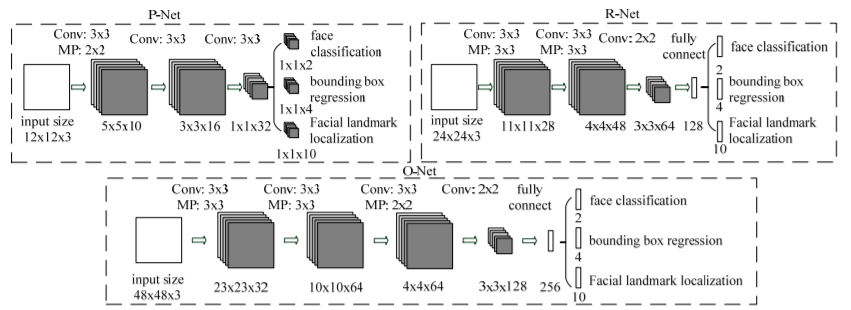

<center>Figure 1. MTCNN architecture: P-Net, R-Net, O-Net</center>
<center>Source: https://sefiks.com/2020/09/09/deep-face-detection-with-mtcnn-in-python/</center>

We can also visualize the model architecture by printing it out.

In [7]:
print(model)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

Let's test our model's ability to work with our data. We'll begin by loading two images:
1. A solo picture
2. A group picture

This will help us evaluate whether our face detection algorithm is capable of detecting a single face in a photo as well as multiple faces in a single photo.

In [10]:
# Sample Images
img_bj = Image.open(os.path.join(file_folder, image_data[0])).convert('RGB')
img_cpt = Image.open(os.path.join(file_folder, image_data[34])).convert('RGB')

Once the images are loaded, we utilize our model to detect the faces within them.

In [11]:
# Pretrained Model Face Detection
bboxes_bj, pred_bj = model.detect(img_bj)
bboxes_cpt, pred_cpt = model.detect(img_cpt)

Next, we create a function `detect_face` that accepts an `image`, a `bounding box` array, and a `prediction` array (which are the outputs of the model.detect() method) and generates a plot of the image with the bounding boxes and prediction confidence overlaid.

In [12]:
def detect_face(image, bboxes, pred):
    """
    Accepts the an `image`, bounding box array `bboxes`, and prediction
    array `pred` output of model.detect() and plots the images,
    bounding boxes, and prediction confidence.
    """
    num_persons = len(pred)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i, box in enumerate(bboxes):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rectangle = Rectangle((x1, y1), width, height, fill=False, ec='tab:red', linewidth = 2)
        ax.text(x1, y1+120, str(round(pred[i], 4)*100) + '%', fontsize= 8, color='red')
        ax.add_patch(rectangle)
    ax.set_title(f'Sample Face Detection Result For {num_persons} Person/s')

    ax.axis('off');

Below are the results of the face detection algorithm for images containing both a single face and multiple faces.

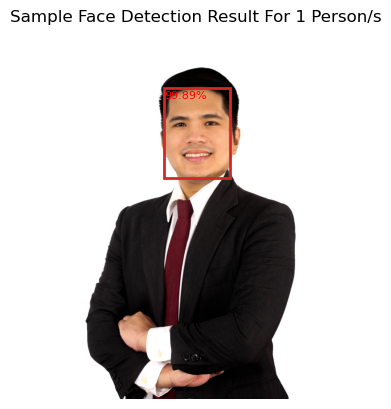

In [17]:
detect_face(img_bj, bboxes_bj, pred_bj)

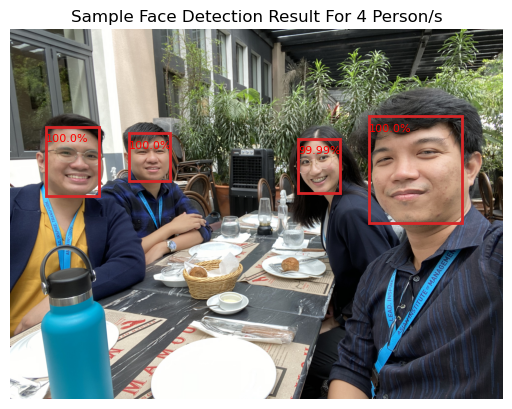

In [18]:
detect_face(img_cpt, bboxes_cpt, pred_cpt)

We utilize the face detection model to detect faces in each image. The detected faces are then cropped using the predicted bounding boxes and saved to a local directory `data\\cropped_faces`. We do this for all `116 images`.

In [19]:
def save_face(file_folder, save_path, image_data):
    """
    Detects and crops the faces from images and saves it to a directory.
    """
    counter_i = 0
    for index, image_path in enumerate(image_data):

        img = Image.open(os.path.join(file_folder, image_path)).convert('RGB')
        bboxes, pred = model.detect(img)

        for ind, dim in enumerate(bboxes):
            
            if pred[ind] > 0.95:
                box = tuple(dim)
                crop_img = img.crop(box)
                crop_img.save(f'{save_path}\\face_{counter_i}.jpg', 'JPEG')
                counter_i +=1

In [20]:
file_folder = 'data\\images'
save_path = 'data\\cropped_faces'

save_face(file_folder, save_path, image_data)

Our model, utilizing a threshold of 0.95, was able to successfully detect 258 faces. These images were then sorted into five classes, with each class representing a team member as follows:

- **Class 1** - bj
- **Class 2** - greg
- **Class 3** - loraine
- **Class 4** - rozz
- **Class 5** - others

The images were manually sorted into directories that are labeled with their respective class name. Below is a summary of the number of images for each class:

**Directory:** data\\face_data\\{class_name}

- **bj** - 34 images
- **greg** - 36 images
- **loraine** - 30 images
- **rozz** - 55 images
- **others** - 103 images

In the next notebook, we will not be using the data from the `others` class in our facial classification since we are only interested in the faces of the Capstone team members.

# References

[1] Serengil, S. (2020). Deep Face Detection with MTCNN in Python. Retrieved from https://sefiks.com/2020/09/09/deep-face-detection-with-mtcnn-in-python/

[2] Chintaram, Y. (2021). Automating Attendance System using Face Recognition with Masks. Retrieved from https://github.com/yudhisteer/Face-Recognition-with-Masks

[3] Elgendy, M. (2020, November 10). Deep Learning for Vision Systems. Manning Publications Co.
*Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 documentation*. (n.d.). Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 Documentation. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

[4] Alzubaidi, L., Santamaría, J., Manoufali, M., Mohammed, B., Fadhel, M. A., Zhang, J., Al-Timemy, A.H., Al-Shamma, O. & Duan, Y. (2021). MedNet: pre-trained convolutional neural network model for the medical imaging tasks. *arXiv preprint* arXiv:2110.06512.

[5] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 770-778).

[6] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4700-4708).

[7] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). Imagenet classification with deep convolutional neural networks. *Communications of the ACM*, 60(6), 84-90.

[8] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). Mobilenetv2: Inverted residuals and linear bottlenecks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4510-4520).

[9] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. *arXiv preprint* arXiv:1409.1556.

[10] Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In *International conference on machine learning* (pp. 6105-6114). PMLR.